In [3]:
import numpy as np
import matplotlib.pyplot as plt
import astroML

if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

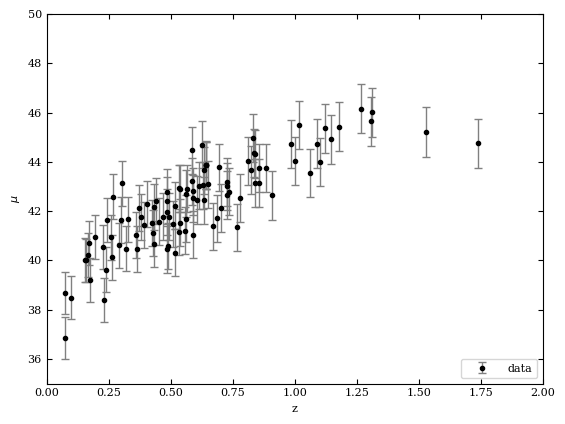

In [73]:
from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50);

x = np.array(z_sample)
y = np.array(mu_sample)

## Linear regression 

39.60456481105869 [4.5911933]


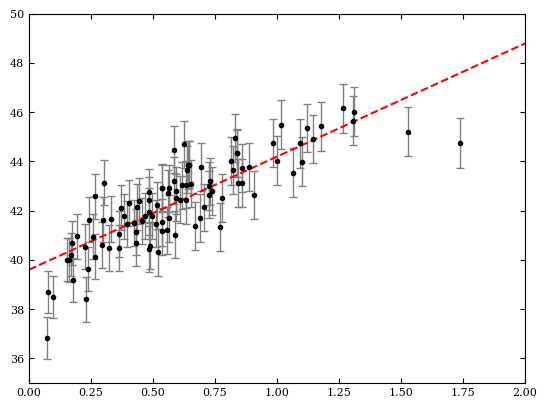

In [74]:
from sklearn.linear_model import LinearRegression

X = x[:, np.newaxis]
y = mu_sample

lin_reg = LinearRegression()
lin_reg.fit(X, y, sample_weight=dmu)

theta0 = lin_reg.intercept_
theta1 = lin_reg.coef_

print(theta0, theta1)

x_new = np.array([[0], [2]]) #like X_grid, but just with the endpoints
y_pred = lin_reg.predict(x_new)

plt.errorbar(x, y, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(x_new,y_pred, ls='--', c='red')
plt.xlim(0,2)
plt.ylim(35,50);


## Polynomial

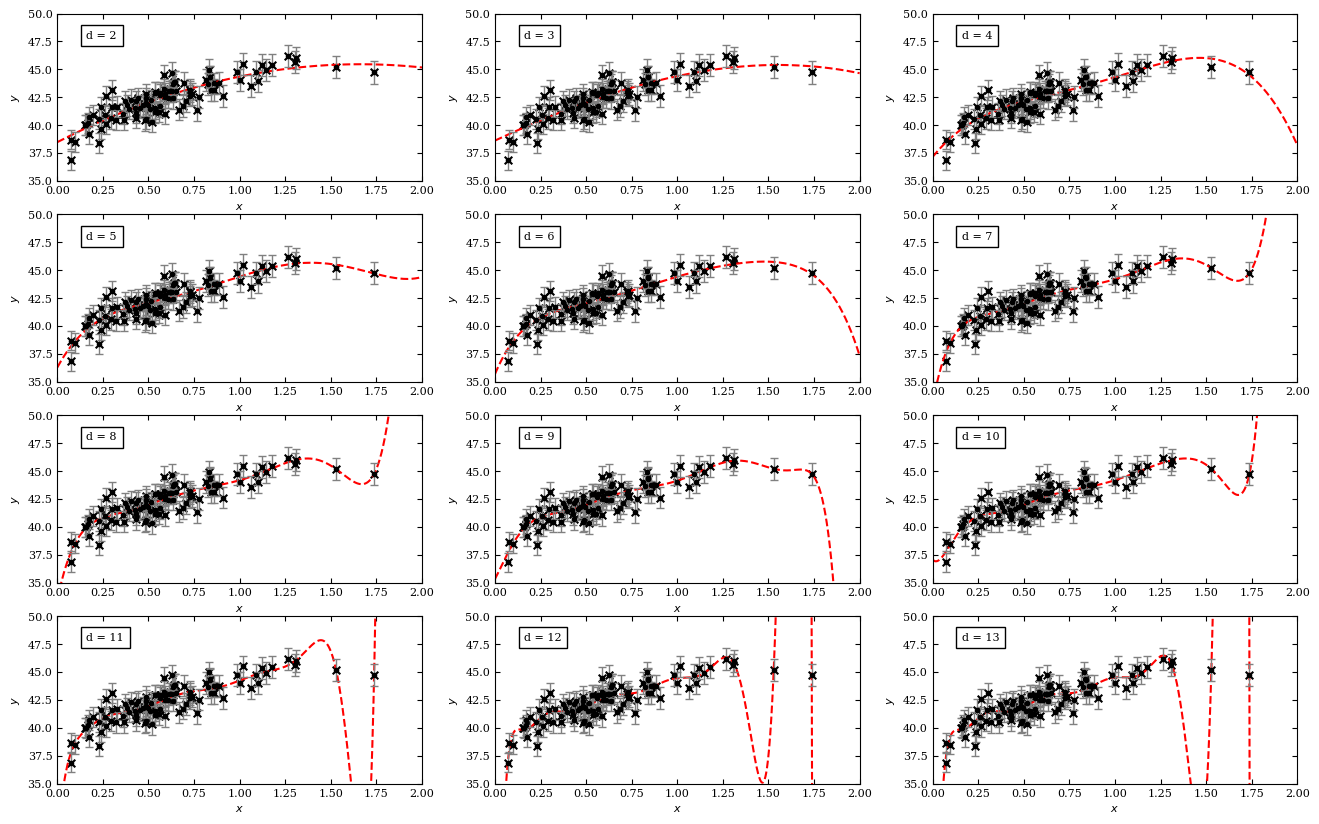

In [75]:
fig,axs = plt.subplots(4,3, figsize=(16,10))
c_axs = np.concatenate(axs)


d = np.arange(2,14)

for d_i, ax in zip(d, c_axs):
    ax.scatter(x, y, marker='x', c='k', s=30)

    p = np.polyfit(x, y, d_i, w=dmu)
    x_fit = np.linspace(0, 2, 1000)
    y_fit = np.polyval(p, x_fit)


    ax.plot(x_fit, y_fit, c='r', ls='--')
    ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
    ax.set_ylim(35,50)
    ax.set_xlim(0, 2)

    ax.set_ylabel('$y$')
    ax.set_xlabel('$x$')
    ax.text(0.08, 0.9, "d = %i" % d_i, transform=ax.transAxes,
            ha='left', va='top',
            bbox=dict(ec='k', fc='w'));
    


In [76]:
#cross validation data
x_n = np.array(np.split(x, 4))
y_n = np.array(np.split(y, 4))
dmu_n = np.array(np.split(dmu, 4))

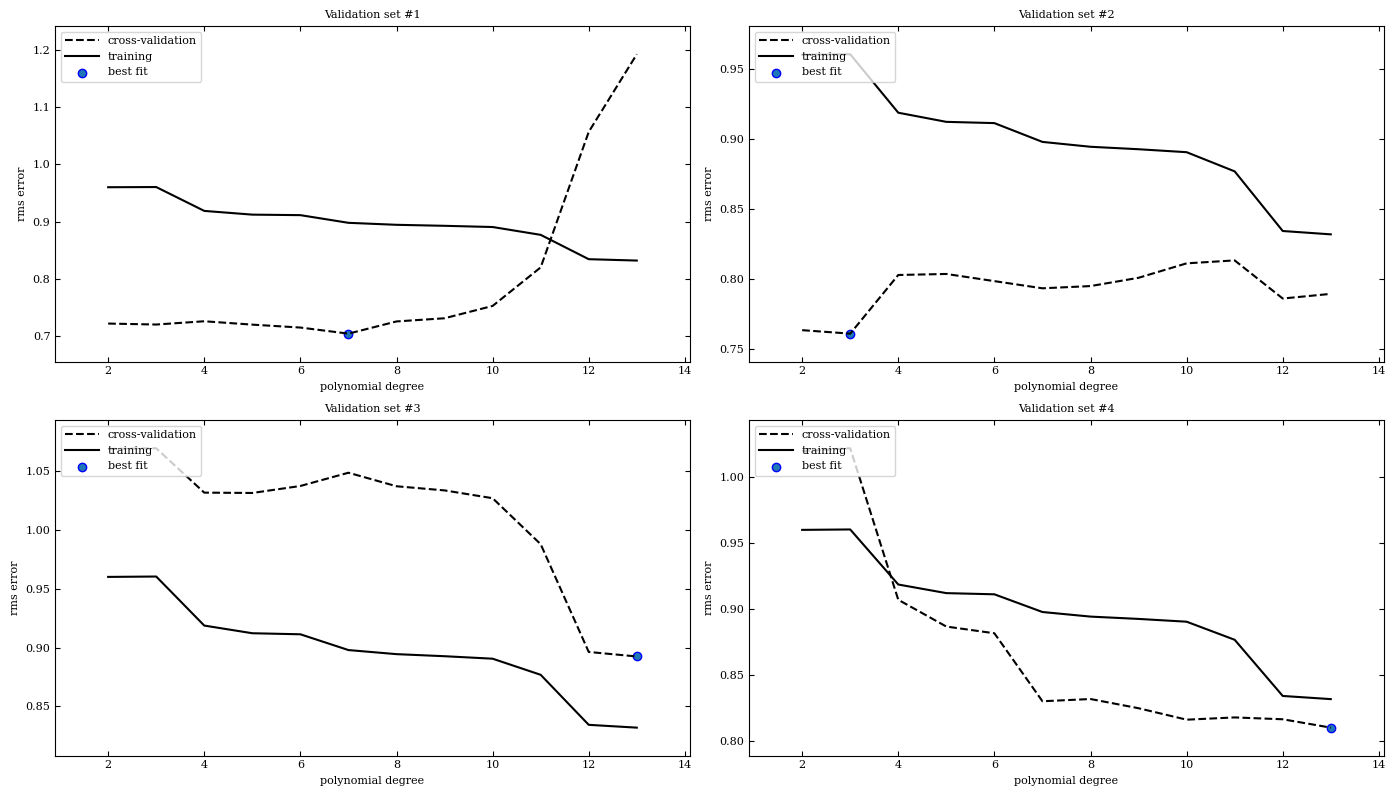

In [77]:
training_err = np.zeros(d.shape)
crossval_err = np.zeros(d.shape)

fig,axs = plt.subplots(2,2, figsize=(14,8)) #4 crossvalidations 
c_axs = np.concatenate(axs)

bfs = []

for j,ax in enumerate(c_axs):
    #selcting training set and test set
    x_cv = x_n[j]
    y_cv = y_n[j]
    dmu_cv = dmu_n[j] 

    xtrain = np.delete(x_n, np.argwhere(x_n==x_cv)).flatten() 
    ytrain = np.delete(y_n, np.argwhere(y_n==y_cv)).flatten() 
    dmu_t = np.delete(dmu_n, np.argwhere(dmu_n==dmu_cv)).flatten() 

    for i, d_i in enumerate(d):
        #testing the set and computing cv and training err
        p = np.polyfit(xtrain, ytrain, d_i, w=dmu_t)

        training_err[i] = np.sqrt(np.sum((np.polyval(p, xtrain) - ytrain) ** 2)
                                  / len(ytrain))
        crossval_err[i] = np.sqrt(np.sum((np.polyval(p, x_cv) - y_cv) ** 2)
                                  / len(y_cv))

    #plotting results for each of the 4 cv sets
    dist = abs(crossval_err - training_err)
    best = np.min(crossval_err)
    xbest = d[crossval_err==best]
    bfs.append(xbest)

    ax.plot(d, crossval_err, '--k', label='cross-validation')
    ax.plot(d, training_err, '-k', label='training')
    ax.scatter(xbest, crossval_err[xbest-2], label='best fit')

    ax.set_xlabel('polynomial degree')
    ax.set_ylabel('rms error')
    ax.set_title(f'Validation set #{j+1}')
    ax.legend(loc=2)
    ax.margins(.1)

    plt.tight_layout()

plt.show();

Why does the error change so much by using different validation sets?

### How do i split the data?

I'm splitting data, but the data is not ordered so i don't see the gap in between

(0.0, 2.0)

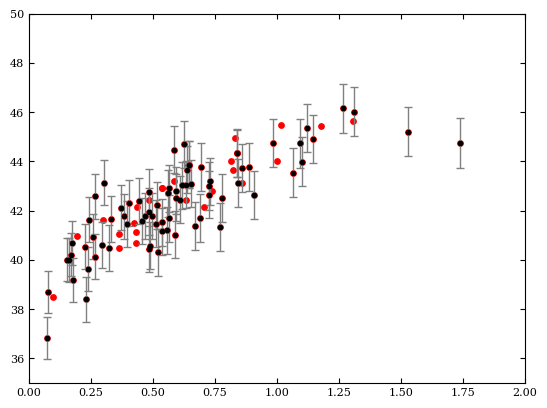

In [78]:
x_cv = x_n[0]
y_cv = y_n[0]
dmu_cv = dmu_n[0] 

xtrain = np.delete(x_n, np.argwhere(x_n==x_cv)).flatten() 
ytrain = np.delete(y_n, np.argwhere(y_n==y_cv)).flatten() 
dmu_t = np.delete(dmu_n, np.argwhere(dmu_n==dmu_cv)).flatten()

plt.errorbar(xtrain, ytrain, dmu_t, fmt='.k', ecolor='gray', lw=1,label='data')
plt.scatter(x, y, s=15,color='red')
plt.ylim(35,50)
plt.xlim(0, 2)

## Setting up a new CV algorithm

Using `GridSearchCV` doesn't work, i tried in many ways. I have to implement it myself, let's try to build a general function for all type of regressors.
I wanted to build a k-fold cv method so we will leave the option to split the data but i couldn't manage to do it

In [79]:
X = z_sample[:,np.newaxis]
y = mu_sample
dy = dmu

In [80]:
from sklearn.model_selection import train_test_split

X_train, X_cv, ydy_train, ydy_cv = train_test_split(X, np.array([y,dy]).T, test_size=0.3, random_state=42)
y_train,dy_train = ydy_train.T
y_cv,dy_cv = ydy_cv.T

In [81]:
def geterror(X,y,classifier):
    return np.sqrt( np.sum(( y - classifier.predict(X) )**2) / len(X) )

def fitanderror(classifier):
    classifier.fit(X_train, y_train, dy_train)
    error_train = geterror(X_train, y_train, classifier)
    error_validation  = geterror(X_cv, y_cv, classifier)
    return error_train, error_validation

Let's test it out

In [82]:
classifier = astroML.linear_model.LinearRegression()
error_train, error_validation = fitanderror(classifier)
print("Linear Regression", error_train, error_validation)

Linear Regression 1.0485115996674979 0.8238924629073958


---

## Basis function regression

In [83]:
#Basis function regression looks like this
from astroML.linear_model import BasisFunctionRegression

# data from linear regression scheme
X = x[:, np.newaxis]
y = mu_sample

xgrid = np.linspace(0,2,100)
xgrid = xgrid[:, None]

# mean positions of the 10 Gaussians in the model
X_gridtest = np.linspace(0,2,100)[:, None]
# widths of these Gaussians
s_test = np.linspace(1,12,6)

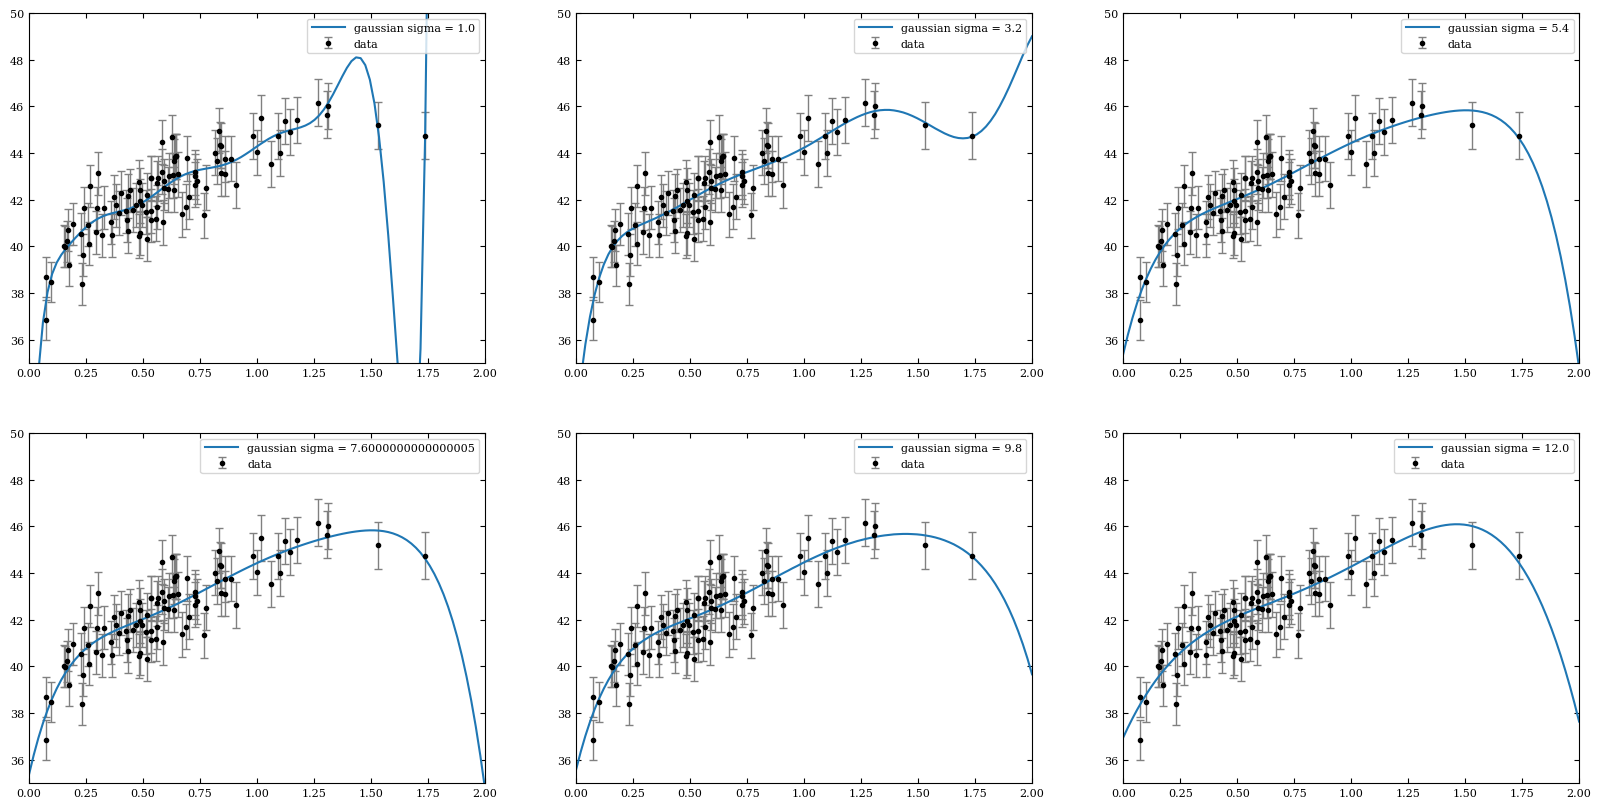

In [84]:
fig,axs = plt.subplots(2,3, figsize=(20,10))
c_axs = np.concatenate(axs)

for s, ax in zip(s_test,c_axs):
    bfr = BasisFunctionRegression('gaussian', mu=X_gridtest, sigma=s)
    bfr.fit(X,y,dmu)
    y_pred = bfr.predict(xgrid)
    
    ax.errorbar(x, y, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
    ax.plot(xgrid, y_pred, label=f'gaussian sigma = {s}')
    
    ax.set_xlim(0,2)
    ax.set_ylim(35,50)
    ax.legend(loc = 'upper right');

In [85]:
s_test = np.linspace(1,12,int(1e2))

etrain, etest= [], []

for s in s_test:
    bfr = BasisFunctionRegression('gaussian', mu=X_gridtest, sigma=s)
    error_train, error_cv = fitanderror(bfr)
    etrain.append(error_train)
    etest.append(error_cv)

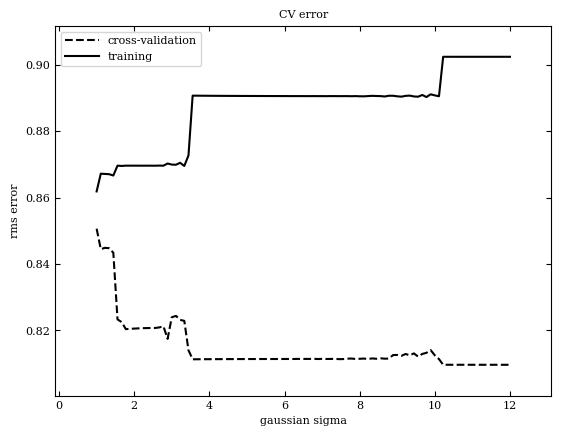

In [86]:
plt.plot(s_test, etest, '--k', label='cross-validation')
plt.plot(s_test, etrain, '-k', label='training')

plt.xlabel('gaussian sigma')
plt.ylabel('rms error')
plt.title(f'CV error')
plt.legend(loc=2)
plt.margins(.1)

## Kernel function regression

In [87]:
from astroML.linear_model import NadarayaWatson

X = x[:, np.newaxis]
y = mu_sample

xgrid = np.linspace(0,2,100)
xgrid = xgrid[:, None]

# mean positions of the 10 Gaussians in the model
X_gridtest = np.linspace(0,2,100)[:, None]
# widths of these Gaussians
h_test = [.01, .05, .1, .25, .5, 1]

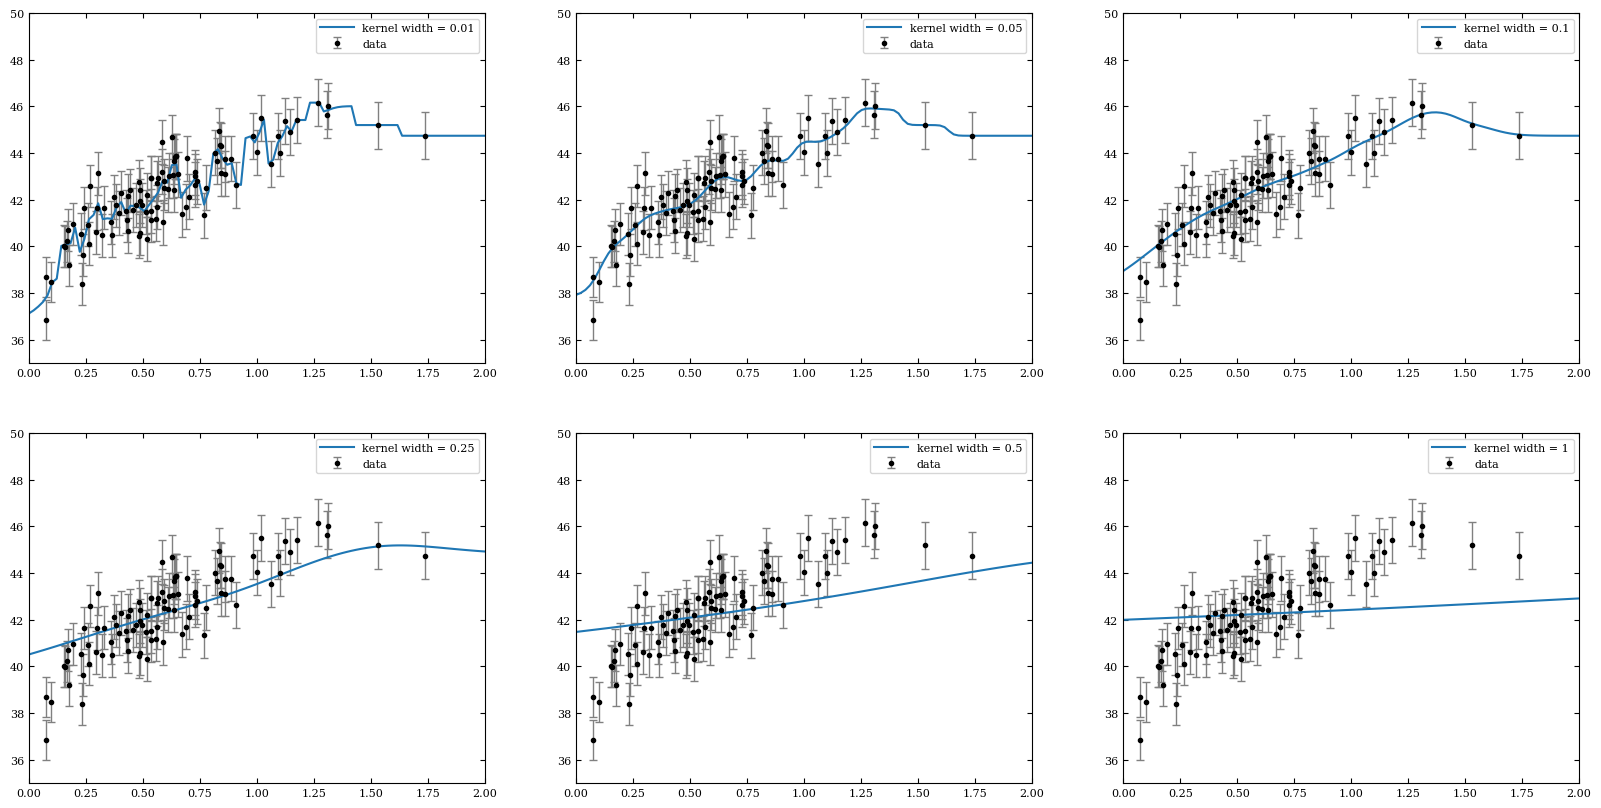

In [88]:
fig,axs = plt.subplots(2,3, figsize=(20,10))
c_axs = np.concatenate(axs)

for h, ax in zip(h_test,c_axs):
    kfr = NadarayaWatson(kernel='gaussian', h=h)
    kfr.fit(X,y,dmu)
    y_pred = kfr.predict(xgrid)
    
    ax.errorbar(x, y, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
    ax.plot(xgrid, y_pred, label=f'kernel width = {h}')
    
    ax.set_xlim(0,2)
    ax.set_ylim(35,50)
    ax.legend();

In [89]:
h_test = np.linspace(.01,2,int(1e2))

etrain, etest= [], []

for h in h_test:
    kfr = NadarayaWatson(kernel='gaussian', h=h)
    error_train, error_cv = fitanderror(kfr)
    etrain.append(error_train)
    etest.append(error_cv)

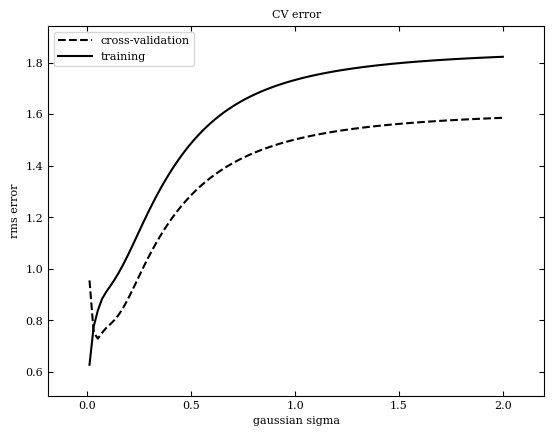

In [90]:
plt.plot(h_test, etest, '--k', label='cross-validation')
plt.plot(h_test, etrain, '-k', label='training')

plt.xlabel('gaussian sigma')
plt.ylabel('rms error')
plt.title(f'CV error')
plt.legend(loc=2)
plt.margins(.1)